In [ ]:
!pip install --upgrade --no-deps keras keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [ ]:
!pip install tensorflow==2.15.0 keras keras-tuner tensorflow-addons==0.23.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PIL import Image
import keras_tuner as kt
import tensorflow_addons as tfa
from google.colab import drive
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Lambda, Activation, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


- Carichiamo la parte convoluzionale del modello ResNet50 pre-addestrato su ImageNet

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
conv_base.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 261, 261, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

- Congeliamo tutti i livelli della base convoluzionale di ResNet50 tranne gli ultimi 34 livelli

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-34]:
    layer.trainable = False

- Carichiamo da kaggle la cartella contenente le immagini di dataset


In [ ]:
import os
import zipfile

# 1. Verifica che il file kaggle.json sia presente
kaggle_json = "kaggle.json"

if not os.path.exists(kaggle_json):
    raise FileNotFoundError("Il file 'kaggle.json' non è stato trovato nella cartella corrente. ")

# 2. Copia kaggle.json nella cartella .kaggle dell’utente
print(" Configurazione dell'API Kaggle...")
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

with open(kaggle_json, "rb") as src:
    with open(os.path.join(kaggle_dir, "kaggle.json"), "wb") as dst:
        dst.write(src.read())

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# 3. Installa la libreria kaggle (se non è installata)
try:
    import kaggle
except ImportError:
    print(" Installazione della libreria kaggle...")
    !pip install -q kaggle

# 4. Scarica il dataset
print("\n Download del dataset da Kaggle...")
!kaggle datasets download -d fatemehmehrparvar/lung-disease -p ./dataset --force

# 5. Estrai lo ZIP
zip_path = "./dataset/lung-disease.zip"
extract_path = "./lung_decompressed"

print(" Estrazione del file zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 6. Verifica i file
print("\n Download e decompressione completati.")
print(" File estratti:")
print(os.listdir(extract_path))

- Definizione dei percorsi delle immagini




In [ ]:
import os

base_dir = os.path.join(".", "lung_decompressed", "Lung X-Ray Image", "Lung X-Ray Image")

lung_opacity = os.path.join(base_dir, "Lung_Opacity")
normal = os.path.join(base_dir, "Normal")
viral_pne = os.path.join(base_dir, "Viral Pneumonia")

- Carichiamo le immagini negli array delle features e delle labels


In [ ]:
features = []
labels = []

for img in tqdm(os.listdir(lung_opacity)):
    img_path = os.path.join(lung_opacity, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(normal)):
    img_path = os.path.join(normal, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

for img in tqdm(os.listdir(viral_pne)):
    img_path = os.path.join(viral_pne, img)
    image = cv2.imread(img_path)
    image = cv2.resize(image, (255, 255))
    features.append(image)

100%|██████████| 1100/1100 [00:01<00:00, 767.01it/s]


- Aggiungiamo le etichette per ogni classe




In [ ]:
for img in os.listdir(lung_opacity):
    labels.append(0)
for img in os.listdir(normal):
    labels.append(1)
for img in os.listdir(viral_pne):
    labels.append(2)

- Mostriamo delle immagini casuali con le relative etichette

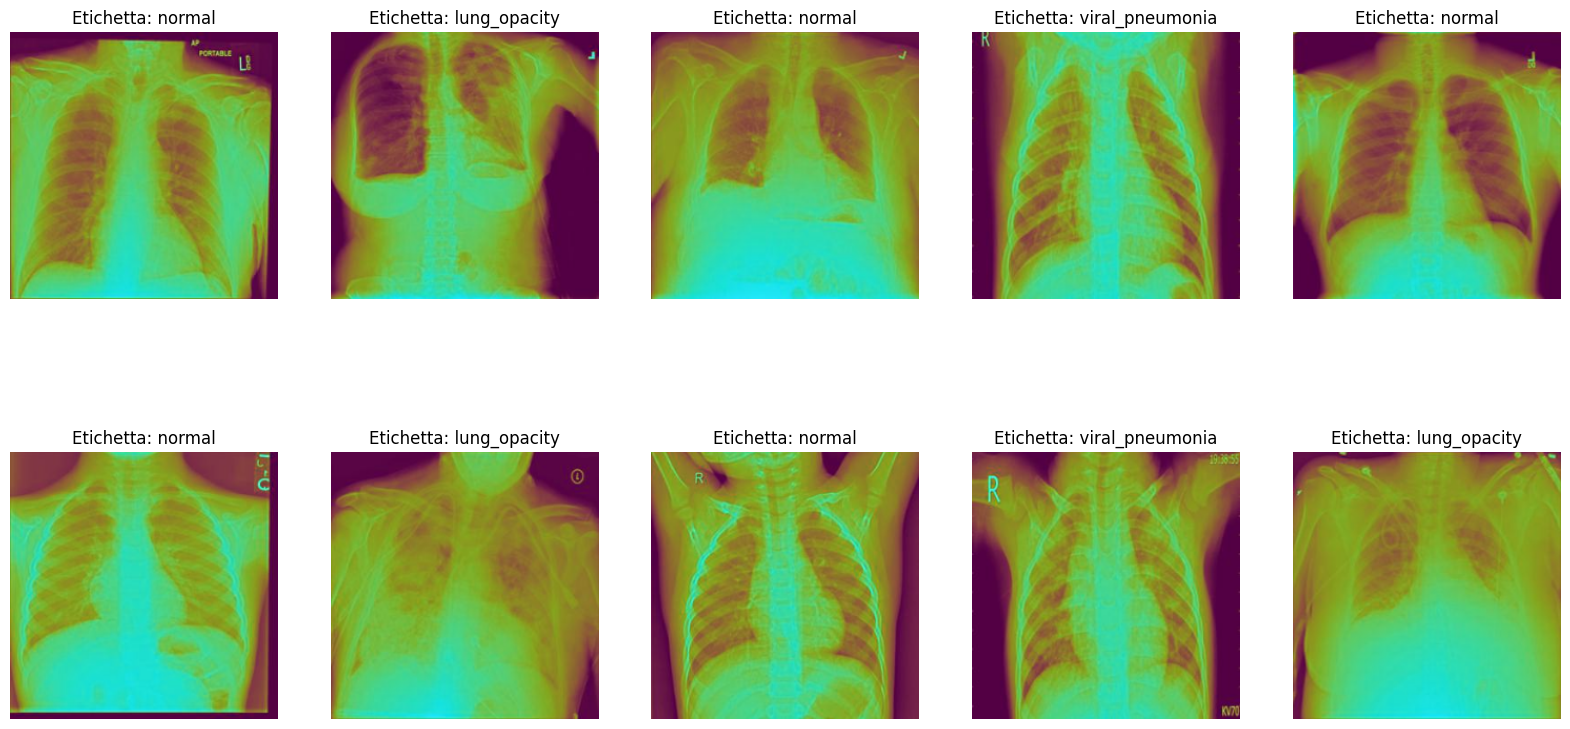

In [ ]:
label_names = {0: 'lung_opacity', 1: 'normal', 2: 'viral_pneumonia'}

indices = np.arange(len(features))
np.random.shuffle(indices)
features = np.array(features)[indices]
labels = np.array(labels)[indices]

num_images_to_display = min(10, len(features))

plt.figure(figsize=(20, 10))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i].astype('uint8'))
    plt.title(f'Etichetta: {label_names[labels[i]]}')
    plt.axis('off')
plt.show()

- Conversione delle features e delle labels in array numpy

In [ ]:

X = np.array(features)
y = np.array(labels)

- Prima dividiamo in training e test set (80% training, 20% test)
- Poi dividiamo il training set rimanente in training e validation set (80% training, 20% validation)


In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

- Conversione delle etichette in formato categorico


In [ ]:
y_trainE = to_categorical(y_train, num_classes=3)
y_valE = to_categorical(y_val, num_classes=3)
y_testE = to_categorical(y_test, num_classes=3)

# Modello
- Definizione di build_model per il tuning degli iperparametri

In [ ]:
def build_model(hp):
    datagen = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2)]
    )

    inputs = Input(shape=(255, 255, 3))
    x = datagen(inputs)
    x = tf.keras.layers.Lambda(lambda x: tf.keras.applications.resnet.preprocess_input(x))(x)
    x = conv_base(x)
    x = Flatten()(x)
    x = Dropout(hp.Float('dropout_rate_1', 0.3, 0.7))(x)
    x = Dense(hp.Int('units', 64, 256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout_rate_2', 0.3, 0.7))(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)

    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=3)])

    return model



- Effettuiamo la configurazione e la ricerca degli iperparametri

In [ ]:
#tuner_dir = 'hyperparam_tuning/lung_disease_classification'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

tuner = kt.RandomSearch(
    build_model,
    objective= 'val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lung_disease_classification'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

tuner.search(X_train, y_trainE, epochs=10, validation_data=(X_val, y_valE), callbacks=[early_stopping])


Trial 5 Complete [00h 02m 36s]
val_loss: 0.19571760296821594

Best val_loss So Far: 0.1939144879579544
Total elapsed time: 00h 12m 07s


- Riassunto dei migliori iperparametri trovati

In [ ]:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Il miglior tasso di dropout del primo strato dropout è: {best_hps.get('dropout_rate_1')}
Il miglior numero di unità nel dense layer è: {best_hps.get('units')}
Il miglior tasso di dropout del secondo strato dropout è: {best_hps.get('dropout_rate_2')}
Il miglior learning rate è: {best_hps.get('learning_rate')}
""")



Il miglior tasso di dropout del primo strato dropout è: 0.516711898347532
Il miglior numero di unità nel dense layer è: 128
Il miglior tasso di dropout del secondo strato dropout è: 0.38449955986555223
Il miglior learning rate è: 0.0006047021515893356



- Addestramento finale del modello con i migliori iperparametri

In [ ]:

model = tuner.hypermodel.build(best_hps)
history_fine_tuning = model.fit(X_train, y_trainE, epochs=10, validation_data=(X_val, y_valE), callbacks=[early_stopping])

Epoch 1/10
70/70 [==============================] - 24s 215ms/step - loss: 0.6795 - accuracy: 0.8781 - f1_score: 0.8796 - val_loss: 0.6723 - val_accuracy: 0.9209 - val_f1_score: 0.9224
Epoch 2/10
70/70 [==============================] - 14s 194ms/step - loss: 0.2805 - accuracy: 0.9303 - f1_score: 0.9316 - val_loss: 0.9630 - val_accuracy: 0.9209 - val_f1_score: 0.9229
Epoch 3/10
70/70 [==============================] - 14s 198ms/step - loss: 0.2356 - accuracy: 0.9231 - f1_score: 0.9246 - val_loss: 0.3387 - val_accuracy: 0.9137 - val_f1_score: 0.9161
Epoch 4/10
70/70 [==============================] - 14s 197ms/step - loss: 0.1817 - accuracy: 0.9371 - f1_score: 0.9383 - val_loss: 0.2916 - val_accuracy: 0.9317 - val_f1_score: 0.9338
Epoch 5/10
70/70 [==============================] - 14s 193ms/step - loss: 0.1844 - accuracy: 0.9397 - f1_score: 0.9409 - val_loss: 0.3117 - val_accuracy: 0.9209 - val_f1_score: 0.9225
Epoch 6/10
70/70 [==============================] - 13s 192ms/step - loss: 

- Valutazione e stampa dei risultati del modello

In [ ]:
loss, accuracy, f1  = model.evaluate(X_test, y_testE)


print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")
print(f"f1: {np.mean(f1):.3f}")

22/22 [==============================] - 4s 198ms/step - loss: 0.1844 - accuracy: 0.9367 - f1_score: 0.9364
Test loss: 0.184
Test accuracy: 0.937
f1: 0.936


- Scatterplot

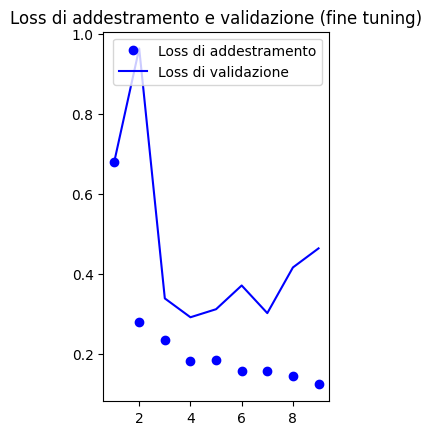

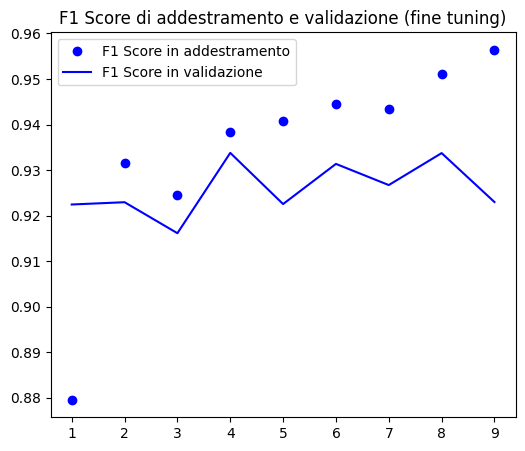

In [ ]:
acc = history_fine_tuning.history['accuracy']
val_acc = history_fine_tuning.history['val_accuracy']
loss = history_fine_tuning.history['loss']
val_loss = history_fine_tuning.history['val_loss']

f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(history_fine_tuning.history['f1_score'][i]))
  val_f1_score.append(np.mean(history_fine_tuning.history['val_f1_score'][i]))

# Plot della perdita (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Loss di addestramento")
plt.plot(epochs, val_loss, "b", label="Loss di validazione")
plt.title("Loss di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()

# Plot dell'F1 score
plt.figure(figsize=(6, 5))
plt.plot(epochs, f1_score, "bo", label="F1 Score in addestramento")
plt.plot(epochs, val_f1_score, "b", label="F1 Score in validazione")
plt.title("F1 Score di addestramento e validazione (fine tuning)")
plt.legend()

plt.show()


Matrice di confusione

22/22 [==============================] - 4s 110ms/step


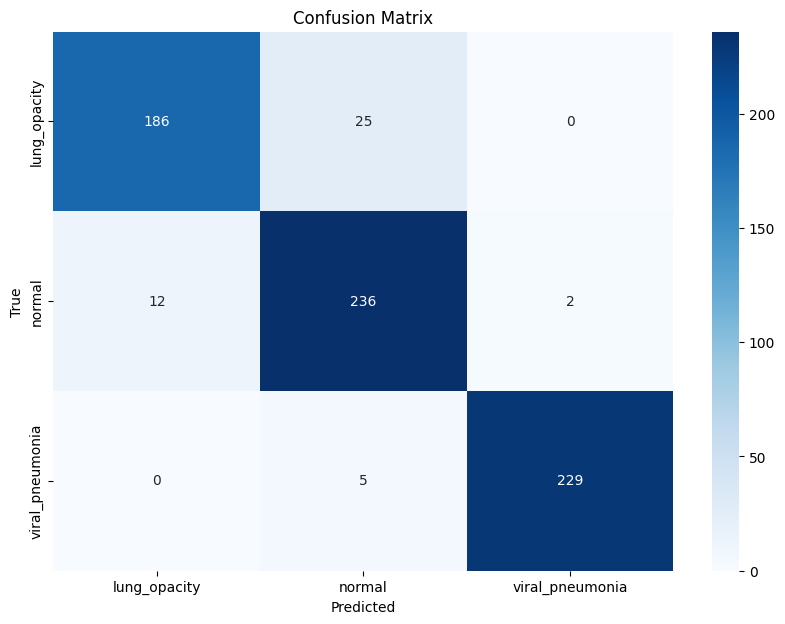

In [ ]:
y_predE = model.predict(X_test)
y_pred = np.argmax(y_predE, axis=1)
y_true = np.argmax(y_testE, axis=1)

cm = confusion_matrix(y_true, y_pred)
cm_labels = ['lung_opacity', 'normal', 'viral_pneumonia']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()